In [ ]:
# the first time to integrate the large iteration process
# rewrite the small iteration process as a function
# 这是一个12场景的基准算例，直接根据负荷生成典型场景，并保存
# 根据这个场景做规划，留下规划第一步的结果
# 还需要认真计算所有的程序运行时间
# 在做关于不确定性的灵敏度分析的时候，需要扩大BESS可以给出的灵活调节范围，不然很容易无解
# 从第一个开始，都给0.9的容量
# 修正BESS的容量为3,调频备用为0.4

In [1]:
import time
import numpy as np
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
# cluster the load into different groups
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import manifold
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# df_pv_original = pd.read_csv("data/day_PV_original.csv", header=None)
# pv_original = df_pv_original.values
# pv_max_value = np.max(pv_original)
# pv_data = pv_original/pv_max_value
# pv_data_save = pd.DataFrame(pv_data)
# pv_data_save.to_csv('data/day_pv.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [3]:
import os
os.environ['LD_LIBRARY_PATH'] += '/home/hmy/matlabrt/v912/runtime/glnxa64:/home/hmy/matlabrt/v912/bin/glnxa64:/home/hmy/matlabrt/v912/sys/os/glnxa64:/home/hmy/matlabrt/v912/extern/bin/glnxa64'
import f_find_nadir
find_nadir = f_find_nadir.initialize()

警告: 名称不存在或不是目录: /home/hmy/SMR-Revise-0914/load_change/C
> 位置：path (第 109 行)
位置: addpath (第 84 行)
位置: startup (第 4 行)


In [4]:
# # from net_load data to get the cluster related variables
# class cluster_net_load:
#     def __init__(self, net_load):
#         self.net_load = net_load
        
#     def get_cluster(self):
#         k = 12
#         kmeans = KMeans(n_clusters=k, random_state = 42)
#         kmeans = KMeans(n_clusters=k)
#         y_pred = kmeans.fit_predict(self.net_load)
#         centers = kmeans.cluster_centers_ 
#         period_day_num = 0
        
#         # get period
#         cluster = y_pred[0]
#         temp1 = []
#         temp2 = []
#         for i in range(len(y_pred)):
#             if y_pred[i] == cluster:
#                 period_day_num = period_day_num+1
#             else:
#                 temp1.append(period_day_num)
#                 temp2.append(cluster)
#                 cluster = y_pred[i]
#                 period_day_num = 1
#         temp1.append(period_day_num)
#         temp2.append(cluster)

#         period = []
#         period.append(temp1)
#         period.append(temp2)
#         period = np.array(period)
#         period_data = pd.DataFrame(period)
#         period_data.to_csv('data/period.csv', sep= ',', encoding='utf-8', header=False, index=False)
        
#         # get cluster day_index and cluster day_num 
#         data_cen = np.r_[self.net_load, centers]
#         k = len(centers)
#         closest_ind = np.arange(k)
#         dist = pairwise_distances(data_cen, metric='euclidean')
#         for i in range(k):
#             closest_ind_tmp = np.where(dist[0:-k, -i-1] == np.min(dist[0:-k, -i-1]))
#             closest_ind[i] = closest_ind_tmp[0][0]

#         center_day = closest_ind+1
#         # reverse
#         center_day = center_day[::-1]
        
#         cluster_day_num = []
#         for cluster in range(0, k):
#             day_cluster = np.argwhere(y_pred==cluster)
#             cluster_day_num.append(len(day_cluster))
#         cluster_day_num = np.array(cluster_day_num)
        
#         cluster_day = []
#         cluster_day.append(center_day)
#         cluster_day.append(cluster_day_num)
#         cluster_day = np.array(cluster_day)
        
#         cluster_day_data = pd.DataFrame(cluster_day)
#         cluster_day_data.to_csv('data/cluster_day.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [5]:
# # 注意：这里直接给出需要规划的场景
# # 聚类程序将被注释
# load_df = pd.read_csv('data/day_load.csv', header=None)
# load_data = load_df.values
# cluster_load_12 = cluster_net_load(10*load_data)
# cluster_load_12.get_cluster()
# # 更新于2023/09/14

In [6]:
# boundary: load, renewable, representative days
class read_data:
    def __init__(self, file_list:list):
        self.file_list = file_list
        
    def get_data(self):
        # load data
        df_load = pd.read_csv(self.file_list[0], header=None)
        load = df_load.values
        # pv data
        df_pv = pd.read_csv(self.file_list[1], header=None)
        pv = df_pv.values
        # cluster_day
        df_cluster_day = pd.read_csv(self.file_list[2], header=None)
        cluster_day = df_cluster_day.values[0]
        cluster_day_num = df_cluster_day.values[1]
        # cluster period
        df_period = pd.read_csv(self.file_list[3], header=None)
        period = df_period.values
        # representative days
        day_num = len(cluster_day)
        day_load = []
        day_pv = []
        for day in range(day_num):
            day_load.append(load[cluster_day[day]-1])
            day_pv.append(pv[cluster_day[day]-1])
            
        day_load = np.array(day_load)
        day_pv = np.array(day_pv)
        
        return day_load, day_pv, cluster_day_num, period

In [7]:
# small module reactors
class small_modular_reactor:
    def __init__(self, invest_decision, cap, output, output_max, output_min, output_change,
                 change_temp, adjust_num, inv_cost, ope_cost, cluster_day_num, period, SMR_droop):
        # number of SMR invested
        self.invest_decision = invest_decision
        # SMR capacity
        self.cap = cap
        # upper
        self.pmax = cap
        # lower
        self.pmin = 0.4*cap
        # RU
        self.RU = 0.4*cap
        # RD
        self.RD = 0.4*cap
        # SMR hourly output
        self.output = output
        # output max
        self.output_max = output_max
        # output min
        self.output_min = output_min
        # output_change
        self.output_change = output_change
        # abs auxiliary variable
        self.change_temp = change_temp
        # adjustments
        self.adjust_num = adjust_num
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period
        self.period = period
        # droop for freuency response
        self.droop = SMR_droop
        
    def get_SMR_cost(self):
        # investment cost
        SMR_inv_cost = self.inv_cost*self.cap*cvx.sum(self.invest_decision)
        day_num = len(self.output)
        SMR_num = self.output[0].shape[0]
        hour_num = self.output[0].shape[1]
        # operation cost
        SMR_ope_cost = 0
        SMR_reserve_cost = 0
        for day_index in range(day_num):
            p = self.output[day_index]
            droop = self.droop[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                for k in range(SMR_num):
                    SMR_reserve = droop[k, t]*0.8
                    SMR_ope_cost = SMR_ope_cost + self.ope_cost*p[k, t]*day_index_num
                    SMR_reserve_cost = SMR_reserve_cost + 0*SMR_reserve*day_index_num
        
        return SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost
    
    def get_SMR_cons(self):
        M = 500
        B = 1e-6
        cons = []
        day_num = len(self.output)
        hour_num = self.output[0].shape[1]
        SMR_num = self.output[0].shape[0]
        for day_index in range(day_num):
            p = self.output[day_index]
            p_min = self.output_min[day_index]
            p_max = self.output_max[day_index]
            z = self.output_change[day_index]
            ut = self.change_temp[day_index]
            zt = self.adjust_num[day_index]
            droop = self.droop[day_index]
            # upper, lower limits
            for t in range(hour_num):
                for k in range(SMR_num):
                    # reserve at the time step, maximum frequency deviation
                    SMR_reserve = droop[k,t]*0.8
                    cons += [SMR_reserve >= 0]
                    cons += [SMR_reserve <= 0.1*self.cap*self.invest_decision[k]]
                    cons += [p[k,t] >= (0.4*self.cap)*self.invest_decision[k]]
                    cons += [p[k,t] <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] + SMR_reserve) <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # # maxmimum power output linearization
                    # cons += [p_max[k,t] >= (SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_max[k,t] <= (self.cap - SMR_reserve)]
                    # cons += [p_max[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_max[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] <= (p_max[k,t])]
                    # # minmimum power output linearization
                    # cons += [p_min[k,t] >= (0.4*self.cap + SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_min[k,t] <= (0.4*self.cap + SMR_reserve)]
                    # cons += [p_min[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_min[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] >= (p_min[k,t])]
            for k in range(SMR_num):
                for t in range(1, hour_num):
                    cons += [p[k,t]-p[k,t-1] <= self.RU]
                    cons += [p[k,t-1]-p[k,t] <= self.RD]
                    cons += [p[k,t]-p[k,t-1] <= z[k,t]]
                    cons += [p[k,t-1]-p[k,t] <= z[k,t]]
                    cons += [z[k,t] <= (p[k,t]-p[k,t-1] + (1-ut[k,t])*M)]
                    cons += [z[k,t] <= (p[k,t-1]-p[k,t] + ut[k,t]*M)]
                    cons += [z[k,t] <= zt[k,t]*M]
                    cons += [z[k,t] >= (zt[k,t]-1)*M + B]
                # the number of adjustemn at each day is limitted
                cons += [cvx.sum(zt[k, :]) <= 4]
        # the inter-day output should also within ramp up/down limits
        for day_index in range(day_num):
            p = self.output[day_index]
            for k in range(SMR_num):
                cons += [p[k, 0]-p[k, -1] <= self.RU]
                cons += [p[k, -1]-p[k, 0] <= self.RD]
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        for period_index in range(1, period_num):
            cluster_index = self.period[1][period_index]
            cluster_index_last = self.period[1][period_index-1]
            p = self.output[cluster_index]
            p_last = self.output[cluster_index_last]
            for k in range(SMR_num):
                cons += [p[k, 0]-p_last[k, -1] <= self.RU]
                cons += [p_last[k, -1]-p[k, 0] <= self.RD]
        
        return cons

In [8]:
# Photovoltaics
class Photovoltaic:
    def __init__(self, invest_decision, Cap_limit, day_pv, output, output_cut,
                 inv_cost, ope_cost, cluster_day_num, PV_droop, PV_inertia):
        # PV capacity
        self.cap = invest_decision
        # PV capacity limit
        self.cap_limit = Cap_limit
        # day output
        self.day_output = day_pv
        # upper
        self.pmax = self.cap
        # lower
        self.pmin = 0
        # daily output variable
        self.output = output
        # daily curtailment variable
        self.output_cut = output_cut
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        self.droop = PV_droop
        # virtual inertia
        self.inertia = PV_inertia
        
    def get_PV_cost(self):
        # investment cost
        PV_inv_cost = self.inv_cost*self.cap
        day_num = self.output.shape[0]
        hour_num = self.output.shape[1]
        # operation cost
        PV_ope_cost = 0
        PV_reserve_cost = 0
        for day_index in range(day_num):
            pv = self.output[day_index]
            day_index_num = self.cluster_day_num[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                PV_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                PV_ope_cost = PV_ope_cost + self.ope_cost*pv[t]*day_index_num
                PV_reserve_cost = PV_reserve_cost + 0*PV_reserve*day_index_num
        return PV_inv_cost, PV_ope_cost, PV_reserve_cost
        
    def get_PV_cons(self):
        cons = []
        day_num = self.output.shape[0]
        hour_num = self.output.shape[1]
        cons += [self.cap <= self.cap_limit]
        cons += [self.cap >= 0]
        for day_index in range(day_num):
            pv_day_output = self.day_output[day_index]
            pv = self.output[day_index]
            pv_c = self.output_cut[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                # PV reserve 
                PV_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                cons += [inertia[t] >= 0]
                cons += [droop[t] >= 0]
                cons += [PV_reserve <= 0.1*pv_day_output[t]*self.pmax]
                cons += [pv[t] >= pv_day_output[t]*self.pmin]
                cons += [pv[t] <= pv_day_output[t]*self.pmax]
                cons += [pv_c[t] >= 0]
                cons += [pv_c[t] <= pv_day_output[t]*self.pmax]
                cons += [(pv[t] + PV_reserve + pv_c[t])  == pv_day_output[t]*self.pmax]
        
        return cons

In [9]:
# Battery energy storage 
class Battery_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, BESS_gamma, eta_c, eta_d,
                 SOC, charge_state, discharge_state, charge_power,
                 discharge_power, max_power_ch, max_power_dis,
                 inv_cost, ope_cost, cluster_day_num, BESS_droop, BESS_inertia):
        # BESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # BESS capacity limit
        self.cap_limit = Cap_limit
        # BESS self discharging
        self.gamma = BESS_gamma
        # BESS SOC cap
        self.SOC_cap = 4*self.cap
        # BESS initial SOC (0.2 SOC cap)
        self.SOC_ini = 0.5*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # state of charge
        self.SOC = SOC
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        self.droop = BESS_droop
        # virtual inertia
        self.inertia = BESS_inertia
        
    def get_BESS_cost(self):
        # investment cost
        BESS_inv_cost = self.inv_cost*self.cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        BESS_ope_cost = 0
        BESS_reserve_cost = 0
        for day_index in range(day_num):
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                BESS_ope_cost = BESS_ope_cost+self.ope_cost*BESS_pc[t]*day_index_num+self.ope_cost*BESS_pd[t]*day_index_num
                BESS_reserve_cost = BESS_reserve_cost + 9*BESS_reserve*day_index_num
        return BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost
        
    def get_BESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        for day_index in range(day_num):
            BESS_SOC = self.SOC[day_index]
            BESS_x_ch = self.charge_state[day_index]
            BESS_x_dis = self.discharge_state[day_index]
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            BESS_pmax_ch = self.pmax_ch[day_index]
            BESS_pmax_dis = self.pmax_dis[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                # BESS reserve 
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                cons += [inertia[t] >= 0]
                cons += [droop[t] >= 0.05]
                # 0916修改，为了做灵敏度分析，扩大BESS参与频率调节的边界
                cons += [BESS_reserve <= 0.6*self.cap]
                # 0917修改,为了做灵敏度分析,限制虚拟惯量的比例
                cons += [inertia[t] <=0.1*self.cap]
                # SOC>=0.2 SOC cap (power stored more than 0.2 SOC cap)
                cons += [BESS_SOC[t] >= (0.2*self.SOC_cap)]
                cons += [BESS_SOC[t] <= (0.95*self.SOC_cap)]
                cons += [BESS_pc[t] >= self.pmin]
                cons += [BESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [BESS_pmax_ch[t] >= (self.cap - BESS_reserve)-(1-BESS_x_ch[t])*M]
                cons += [BESS_pmax_ch[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_ch[t] <= BESS_x_ch[t]*M]
                cons += [BESS_pmax_ch[t] >= -BESS_x_ch[t]*M]
                cons += [BESS_pc[t] <= BESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [BESS_pmax_dis[t] >= (self.cap - BESS_reserve)-(1-BESS_x_dis[t])*M]
                cons += [BESS_pmax_dis[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_dis[t] <= BESS_x_dis[t]*M]
                cons += [BESS_pmax_dis[t] >= -BESS_x_dis[t]*M]
                cons += [BESS_pd[t] <= BESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [BESS_x_ch[t]+BESS_x_dis[t] <= 1]
            cons += [BESS_SOC[0] == self.SOC_ini*(1-self.gamma) + (BESS_pc[0]*self.eta_c-BESS_pd[0]/self.eta_d)]
            cons += [BESS_SOC[-1] == self.SOC_ini]
            for t in range(1, hour_num):
                cons += [BESS_SOC[t] == BESS_SOC[t-1]*(1-self.gamma) + (BESS_pc[t]*self.eta_c-BESS_pd[t]/self.eta_d)]
        return cons

In [10]:
# seasonal energy storage
class Seasonal_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, SOC_cap, SOC_cap_limit, 
                 eta_c, eta_d, SOC_inter_period, SOC_intra_day, charge_state, 
                 discharge_state, charge_power, discharge_power, max_power_ch, 
                 max_power_dis, inv_cost, SOC_inv_cost, ope_cost, 
                 cluster_day_num, period):
        # SESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # SESS capacity limit
        self.cap_limit = Cap_limit
        # SESS SOC cap
        self.SOC_cap = SOC_cap
        # SESS SOC_cap limit
        self.SOC_cap_limit = SOC_cap_limit
        # the initial SOC of one year (0.2 SOC cap)
        self.SOC_ini = 0.3*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # inter period state of charge (initial SOC in each period)
        self.SOC_inter_period = SOC_inter_period
        # intra day state of charge (in each representative day)
        self.SOC_intra_day = SOC_intra_day
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        self.SOC_inv_cost = SOC_inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period of the year 
        self.period = period
        
    def get_SESS_cost(self):
        # investment cost
        SESS_inv_cost = self.inv_cost*self.cap
        SESS_inv_cost = SESS_inv_cost + self.SOC_inv_cost*self.SOC_cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        SESS_ope_cost = 0
        for day_index in range(day_num):
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                SESS_ope_cost = SESS_ope_cost+self.ope_cost*SESS_pc[t]*day_index_num+self.ope_cost*SESS_pd[t]*day_index_num
        return SESS_inv_cost, SESS_ope_cost
        
    def get_SESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        cons += [self.cap >= 0 ]
        cons += [self.SOC_cap <= self.SOC_cap_limit]
        cons += [self.SOC_cap >= 0]
        # intra day constrains
        for day_index in range(day_num):
            SESS_intra_SOC = self.SOC_intra_day[day_index]
            SESS_x_ch = self.charge_state[day_index]
            SESS_x_dis = self.discharge_state[day_index]
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            SESS_pmax_ch = self.pmax_ch[day_index]
            SESS_pmax_dis = self.pmax_dis[day_index]
            for t in range(hour_num):
                cons += [SESS_pc[t] >= self.pmin]
                cons += [SESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [SESS_pmax_ch[t] >= self.cap-(1-SESS_x_ch[t])*M]
                cons += [SESS_pmax_ch[t] <= self.cap]
                cons += [SESS_pmax_ch[t] <= SESS_x_ch[t]*M]
                cons += [SESS_pmax_ch[t] >= -SESS_x_ch[t]*M]
                cons += [SESS_pc[t] <= SESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [SESS_pmax_dis[t] >= self.cap-(1-SESS_x_dis[t])*M]
                cons += [SESS_pmax_dis[t] <= self.cap]
                cons += [SESS_pmax_dis[t] <= SESS_x_dis[t]*M]
                cons += [SESS_pmax_dis[t] >= -SESS_x_dis[t]*M]
                cons += [SESS_pd[t] <= SESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [SESS_x_ch[t]+SESS_x_dis[t] <= 1]
            # the initial SOC at each day is 0
            cons += [SESS_intra_SOC[0] == (SESS_pc[0]*self.eta_c - SESS_pd[0]/self.eta_d)]
            # SOC equation
            for t in range(1, hour_num):
                cons += [SESS_intra_SOC[t] == SESS_intra_SOC[t-1] + (SESS_pc[t]*self.eta_c - SESS_pd[t]/self.eta_d)]
        
        # inter period SOC constrains
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        # the initial and final SOC of SESS
        # the initial SOC of the first period (the year)
        cons += [self.SOC_inter_period[0] == self.SOC_ini]
        # the final SOC of the year
        day_final_period = period[0, -1]
        final_cluster_index = period[1, -1]
        final_SESS_intra_SOC = self.SOC_intra_day[final_cluster_index]
        cons += [(self.SOC_inter_period[-1]+final_SESS_intra_SOC[-1]*day_final_period) == self.SOC_ini]
        # the initial SOC of each period
        for period_index in range(1, period_num):
            period_days = period[0, period_index-1]
            cluster_index = period[1, period_index-1]
            cons += [self.SOC_inter_period[period_index] == 
                         (self.SOC_inter_period[period_index-1] 
                          + self.SOC_intra_day[cluster_index,-1]*period_days)]
        # the SOC at each time step
        for period_index in range(period_num):
            period_days = self.period[0][period_index]
            cluster_index = self.period[1][period_index]
            for period_day_index in range (period_days):
                for t in range(hour_num):
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) <= self.SOC_cap]
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) >= 0.2*self.SOC_cap]
        return cons

In [11]:
# resource candidates
class Resource:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        
    def get_candidates(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        period_num = self.period.shape[1]
        # SMR candidate
        SMR_num = 20
        # SMR parameters
        SMR_cap = 0.5
        SMR_inv_cost = 1200e3
        SMR_ope_cost = 24
        # PV parameters
        PV_cap_limit = 10
        PV_inv_cost = 110e3
        PV_ope_cost = 0
        # BESS parameters
        # 为了满足可行性,调整容量边界为4
        BESS_cap_limit = 3
        BESS_gamma = 0.001
        BESS_eta_c = 0.96
        BESS_eta_d = 0.96
        BESS_inv_cost = 100e3
        BESS_ope_cost = 0
        # SESS parameters
        SESS_cap_limit = 6
        SESS_SOC_cap_limit = 2e6
        SESS_eta_c = 0.6
        SESS_eta_d = 0.6
        SESS_inv_cost = 120e3
        SESS_SOC_inv_cost = 1.3e2
        SESS_ope_cost = 0
        # SMR Variable
        SMR_decision = cvx.Variable(SMR_num, boolean=True)
        SMR_output = {}
        SMR_output_change = {}
        SMR_change_temp = {}
        SMR_adjust_num = {}
        SMR_droop = {}
        SMR_output_max = {}
        SMR_output_min = {}
        for day_index in range(day_num):
            SMR_output[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_change[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_change_temp[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_adjust_num[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_droop[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_max[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_min[day_index] = cvx.Variable((SMR_num, hour_num))
        # PV Variable
        PV_decision = cvx.Variable()
        PV_output = cvx.Variable((day_num, hour_num))
        PV_output_cut = cvx.Variable((day_num, hour_num))
        PV_droop = cvx.Variable((day_num, hour_num))
        PV_inertia = cvx.Variable((day_num, hour_num))
        # BESS Variable
        BESS_decision = cvx.Variable()
        BESS_SOC = cvx.Variable((day_num, hour_num))
        BESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_charge_power = cvx.Variable((day_num, hour_num))
        BESS_discharge_power = cvx.Variable((day_num, hour_num))
        BESS_max_power_ch = cvx.Variable((day_num, hour_num))
        BESS_max_power_dis = cvx.Variable((day_num, hour_num))
        BESS_droop = cvx.Variable((day_num, hour_num))
        BESS_inertia = cvx.Variable((day_num, hour_num))
        # SESS Variable
        SESS_decision = cvx.Variable()
        SESS_SOC_cap = cvx.Variable()
        SESS_SOC_inter_period = cvx.Variable(period_num)
        SESS_SOC_intra_day = cvx.Variable((day_num, hour_num))
        SESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_charge_power = cvx.Variable((day_num, hour_num))
        SESS_discharge_power = cvx.Variable((day_num, hour_num))
        SESS_max_power_ch = cvx.Variable((day_num, hour_num))
        SESS_max_power_dis = cvx.Variable((day_num, hour_num))
        # recall SMR to get the cost and cons of SMR
        SMR = small_modular_reactor(SMR_decision, SMR_cap, SMR_output, SMR_output_max,
                                    SMR_output_min, SMR_output_change, SMR_change_temp,
                                    SMR_adjust_num, SMR_inv_cost, SMR_ope_cost,
                                    cluster_day_num, period, SMR_droop)
        # recall Photovoltaic to get the cost and cons of PV
        PV = Photovoltaic(PV_decision, PV_cap_limit, day_pv, PV_output,
                          PV_output_cut, PV_inv_cost, PV_ope_cost, cluster_day_num,
                          PV_droop, PV_inertia)
        # recall BESS to get the cost and cons of BESS
        BESS = Battery_Energy_storage(BESS_decision, BESS_cap_limit, BESS_gamma,
                                      BESS_eta_c, BESS_eta_d, BESS_SOC,
                                      BESS_charge_state, BESS_discharge_state,
                                      BESS_charge_power, BESS_discharge_power,
                                      BESS_max_power_ch, BESS_max_power_dis,
                                      BESS_inv_cost, BESS_ope_cost, cluster_day_num,
                                      BESS_droop, BESS_inertia)
        # recall SESS to get the cost and cons of SESS
        SESS = Seasonal_Energy_storage(SESS_decision, SESS_cap_limit, SESS_SOC_cap,
                                       SESS_SOC_cap_limit, SESS_eta_c, SESS_eta_d,
                                       SESS_SOC_inter_period, SESS_SOC_intra_day,
                                       SESS_charge_state, SESS_discharge_state,
                                       SESS_charge_power, SESS_discharge_power,
                                       SESS_max_power_ch, SESS_max_power_dis,
                                       SESS_inv_cost, SESS_SOC_inv_cost,
                                       SESS_ope_cost, cluster_day_num, period)
        
        return SMR, PV, BESS, SESS

In [12]:
class Plan_optimization:
    def __init__(self, SMR, PV, BESS, SESS, load_level):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.load_level = load_level
    
    def get_cost(self):
        # cost
        fop = 0
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = self.SMR.get_SMR_cost()
        fop = fop + SMR_inv_cost + SMR_ope_cost + SMR_reserve_cost
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = self.PV.get_PV_cost()
        fop = fop + PV_inv_cost + PV_ope_cost + PV_reserve_cost
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = self.BESS.get_BESS_cost()
        fop = fop + BESS_inv_cost + BESS_ope_cost + BESS_reserve_cost
        SESS_inv_cost, SESS_ope_cost = self.SESS.get_SESS_cost()
        fop = fop + SESS_inv_cost + SESS_ope_cost
        
        return fop
    
    def get_cons(self, day_load):
        day_num = day_load.shape[0]
        hour_num = day_load.shape[1]
        # constraints
        cons = []
        cons += self.SMR.get_SMR_cons()
        cons += self.PV.get_PV_cons()
        cons += self.BESS.get_BESS_cons()
        cons += self.SESS.get_SESS_cons()
        # power balance
        for day_index in range(day_num):
            SMR_p = self.SMR.output[day_index]
            PV_p = self.PV.output[day_index]
            BESS_pc = self.BESS.charge_power[day_index]
            BESS_pd = self.BESS.discharge_power[day_index]
            SESS_pc = self.SESS.charge_power[day_index]
            SESS_pd = self.SESS.discharge_power[day_index]
            load_real = self.load_level*day_load[day_index]
            for t in range(hour_num):
                cons += [(cvx.sum(SMR_p[:, t])+PV_p[t]
                          + BESS_pd[t]+SESS_pd[t])
                         == (BESS_pc[t] + SESS_pc[t] + load_real[t])]
        # 惯量参数修改为5
        SMR_inertia = 5
        SMR_damping = 0.6
        SMR_Gain = 0.67
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        for day_index in range(day_num):
            load_ratio = day_load[day_index]
            SMR_day_droop = self.SMR.droop[day_index]
            for t in range(hour_num):
                H = H_SMR+ self.BESS.inertia[day_index, t] + self.PV.inertia[day_index, t]
                # H = H_SMR + self.PV.inertia[day_index, t]
                K = SMR_Gain*cvx.sum(SMR_day_droop[:, t]) + self.BESS.droop[day_index, t] + self.PV.droop[day_index, t]
                # 0916修改，.125的负荷波动修改为0.05, 0.0575, 0.065,0.0725,0.08
                cons += [2*H*0.5 >= 0.0725*self.load_level*load_ratio[t]]
                cons += [(D_SMR+K)*0.5 >= 0.0725*self.load_level*load_ratio[t]]

        return cons
    
    def slove_optim(self, fop, cons):
        obj = cvx.Minimize(fop)
        prob = cvx.Problem(obj, cons)
        prob.solve(solver=cvx.GUROBI, reoptimize=True)
        status = prob.status
        solution = obj.value
        
        return status, solution

In [13]:
class freq_check:
    def __init__(self, SMR, PV, BESS, SESS, load_level, day_load):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.load_level = load_level
        self.day_load = day_load
        
    def condition(self, x):
        return abs(x) > 0.8
        
    def get_condition(self):
        SMR_inertia = 4.5
        SMR_damping = 0.6
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/60
        f_max = np.empty((day_num, hour_num))
        H_inertia = np.empty((day_num, hour_num))
        SMR_droop = np.empty((day_num, hour_num))
        PV_droop = np.empty((day_num, hour_num))
        PV_inertia = np.empty((day_num, hour_num))
        BESS_droop = np.empty((day_num, hour_num))
        BESS_inertia = np.empty((day_num, hour_num))
        fast_droop_expand = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            SMR_day_droop = self.SMR.droop[day_index].value
            load_ratio = self.day_load[day_index]
            for t in range(hour_num):
                # 0916修改，.125的负荷波动
                PL = 0.125*self.load_level*load_ratio[t]
                PL = float(PL)
                H = H_SMR.value+self.BESS.inertia[day_index, t].value
                H_inertia[day_index, t] = H
                M = 2*H
                M = float(M)
                D = D_SMR.value
                D = float(D)
                K_smr = sum(SMR_day_droop[:, t])
                SMR_droop[day_index, t] = K_smr
                K_smr = float(K_smr)
                K_pv = self.PV.droop[day_index, t].value
                PV_droop[day_index, t] = K_pv
                PV_inertia[day_index, t] = self.PV.inertia[day_index, t].value
                K_pv = float(K_pv)
                K_b = self.BESS.droop[day_index, t].value
                BESS_droop[day_index, t] = K_b
                BESS_inertia[day_index, t] = self.BESS.inertia[day_index, t].value
                K_b = float(K_b)
                nadir = find_nadir.f_find_nadir(PL, M, D, K_smr, K_pv, K_b)
                f_max[day_index, t] = nadir
                if (abs(nadir) <= 0.8):
                    fast_droop_expand[day_index, t] = self.PV.droop[day_index, t].value + self.BESS.droop[day_index, t].value 
                else:
                    fast_droop_expand[day_index, t] = (1 + 0.3)*(self.PV.droop[day_index, t].value + self.BESS.droop[day_index, t].value)
        # Use the vectorized version of the condition function
        mask = self.condition(f_max)
        return f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand

In [14]:
# get initial result
class first_step_planning:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period

    def get_initial_result(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        load_level = 10
        source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
        SMR, PV, BESS, SESS = source_data.get_candidates()
        Planning = Plan_optimization(SMR, PV, BESS, SESS, load_level)
        fop = Planning.get_cost()
        cons = Planning.get_cons(self.day_load)
        status, solution = Planning.slove_optim(fop, cons)
        freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
        f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
        cost = solution
        cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = SMR.get_SMR_cost()
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
        SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
        cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
        # save variable
        cap_com_save = {}
        SMR_output_save = {}
        PV_output_save = {}
        PV_output_cut_save = {}
        BESS_charge_power_save = {}
        BESS_discharge_power_save = {}
        SESS_charge_power_save = {}
        SESS_discharge_power_save = {}
        cost_save = {}
        cost_com_save = {}
        freq_nadir = {}
        SMR_droop_response = {}
        PV_droop_response = {}
        BESS_droop_response = {}
        SMR_inertia_response = {}
        PV_inertia_response = {}
        BESS_inertia_response = {}
        SMR_damping_response = {}
        cap_com_save[0] = cap_com
        SMR_output = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            for t in range(hour_num):
                SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
        SMR_output_save[0] = SMR_output
        PV_output_save[0] = PV.output.value
        PV_output_cut_save[0] = PV.output_cut.value
        BESS_charge_power_save[0] = BESS.charge_power.value
        BESS_discharge_power_save[0] = BESS.discharge_power.value
        SESS_charge_power_save[0] = SESS.charge_power.value
        SESS_discharge_power_save[0] = SESS.discharge_power.value
        cost_save[0] = cost 
        cost_com_save[0] = cost_com
        freq_nadir[0] = f_max
        SMR_droop_response[0] = SMR_droop
        PV_droop_response[0] = PV_droop
        BESS_droop_response[0] = BESS_droop
        H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/60
        D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/60
        SMR_inertia_response[0] = H_SMR
        PV_inertia_response[0] = PV_inertia
        BESS_inertia_response[0] = BESS_inertia
        SMR_damping_response[0] = D_SMR

        return cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand, \
    cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response

In [15]:
# get iteration result 
class freq_iteration:
    def __init__(self, day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        self.cost = cost
        self.cap_com = cap_com
        self.cost_com = cost_com
        self.mask = mask
        self.H_inertia = H_inertia
        self.D = D
        self.SMR_droop = SMR_droop
        self.PV_droop = PV_droop
        self.BESS_droop = BESS_droop
        self.fast_droop_expand = fast_droop_expand
        self.cap_com_save = cap_com_save
        self.SMR_output_save = SMR_output_save
        self.PV_output_save = PV_output_save
        self.PV_output_cut_save = PV_output_cut_save
        self.BESS_charge_power_save = BESS_charge_power_save
        self.BESS_discharge_power_save = BESS_discharge_power_save
        self.SESS_charge_power_save = SESS_charge_power_save
        self.SESS_discharge_power_save = SESS_discharge_power_save
        self.cost_save = cost_save
        self.cost_com_save = cost_com_save
        self.freq_nadir = freq_nadir
        self.SMR_droop_response = SMR_droop_response
        self.PV_droop_response = PV_droop_response
        self.BESS_droop_response = BESS_droop_response
        self.SMR_inertia_response = SMR_inertia_response
        self.PV_inertia_response = PV_inertia_response
        self.BESS_inertia_response = BESS_inertia_response
        self.SMR_damping_response = SMR_damping_response
        
    def get_freq_ite_result(self):
        cost = self.cost
        cap_com = self.cap_com
        cost_com = self.cost_com
        mask = self.mask
        H_inertia = self.H_inertia
        D = self.D
        SMR_droop = self.SMR_droop
        PV_droop = self.PV_droop
        BESS_droop = self.BESS_droop
        fast_droop_expand = self.fast_droop_expand
        cap_com_save = self.cap_com_save
        SMR_output_save = self.SMR_output_save
        PV_output_save = self.PV_output_save
        PV_output_cut_save = self.PV_output_cut_save
        BESS_charge_power_save = self.BESS_charge_power_save
        BESS_discharge_power_save = self.BESS_discharge_power_save
        SESS_charge_power_save = self.SESS_charge_power_save
        SESS_discharge_power_save = self.SESS_discharge_power_save
        cost_save = self.cost_save
        cost_com_save = self.cost_com_save
        freq_nadir = self.freq_nadir
        SMR_droop_response = self.SMR_droop_response
        PV_droop_response = self.PV_droop_response
        BESS_droop_response = self.BESS_droop_response
        SMR_inertia_response = self.SMR_inertia_response
        PV_inertia_response = self.PV_inertia_response
        BESS_inertia_response = self.BESS_inertia_response
        SMR_damping_response = self.SMR_damping_response
        load_level = 10
        ite = 0
        while mask.any():
            ite = ite+1
            print('ite:', ite)
            source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
            SMR, PV, BESS, SESS = source_data.get_candidates()
            Planning = Plan_optimization(SMR, PV, BESS, SESS, load_level)
            fop = Planning.get_cost()
            cons = Planning.get_cons(day_load)
            day_num = self.day_load.shape[0]
            hour_num = self.day_load.shape[1]
            SMR_inertia = 4.5
            SMR_damping = 0.6
            # frequency security constraints
            H_SMR = SMR_inertia*cvx.sum(SMR.invest_decision)*SMR.cap/60
            D_SMR = SMR_damping*cvx.sum(SMR.invest_decision)*SMR.cap/60
            for day_index in range(day_num):
                SMR_day_droop_temp = SMR.droop[day_index]
                for t in range(hour_num):
                    cons += [(H_SMR + PV.inertia[day_index, t] + BESS.inertia[day_index, t]) >= H_inertia[day_index, t]]
                    cons += [D_SMR >= D]
                    cons += [cvx.sum(SMR_day_droop_temp[:, t]) >= SMR_droop[day_index, t]]
                    cons += [(BESS.droop[day_index, t] + PV.droop[day_index, t]) >= fast_droop_expand[day_index, t]]

            status, solution = Planning.slove_optim(fop, cons)
            
            freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
            f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
            print('nadir:', f_max)
            cost = solution
            cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
            SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost = SMR.get_SMR_cost()
            PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
            BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
            SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
            cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
            cap_com_save[ite] = cap_com
            SMR_output = np.empty((day_num, hour_num))
            for day_index in range(day_num):
                for t in range(hour_num):
                    SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
            SMR_output_save[ite] = SMR_output
            PV_output_save[ite] = PV.output.value
            PV_output_cut_save[ite] = PV.output_cut.value
            BESS_charge_power_save[ite] = BESS.charge_power.value
            BESS_discharge_power_save[ite] = BESS.discharge_power.value
            SESS_charge_power_save[ite] = SESS.charge_power.value
            SESS_discharge_power_save[ite] = SESS.discharge_power.value
            cost_save[ite] = cost 
            cost_com_save[ite] = cost_com
            freq_nadir[ite] = f_max
            SMR_droop_response[ite] = SMR_droop
            PV_droop_response[ite] = PV_droop
            BESS_droop_response[ite] = BESS_droop
            H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/50
            D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/50
            SMR_inertia_response[ite] = H_SMR
            PV_inertia_response[ite] = PV_inertia
            BESS_inertia_response[ite] = BESS_inertia
            SMR_damping_response[ite] = D_SMR

        return cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, \
    SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response

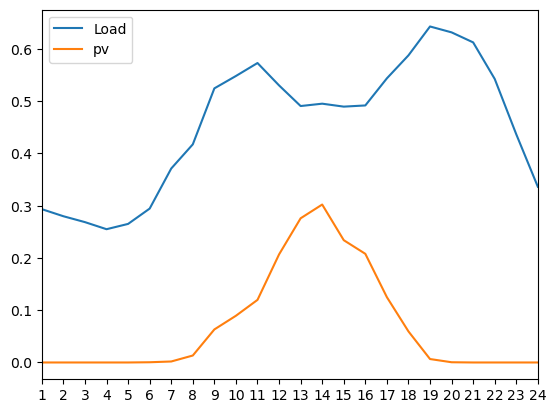

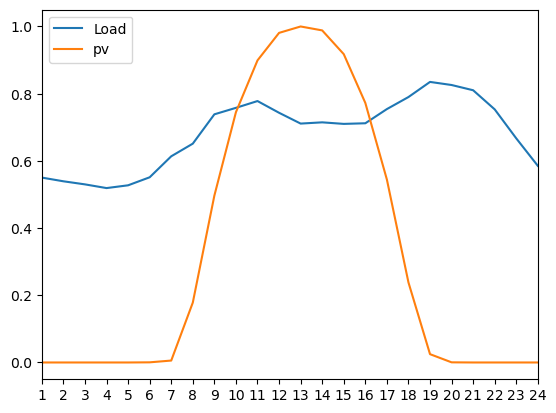

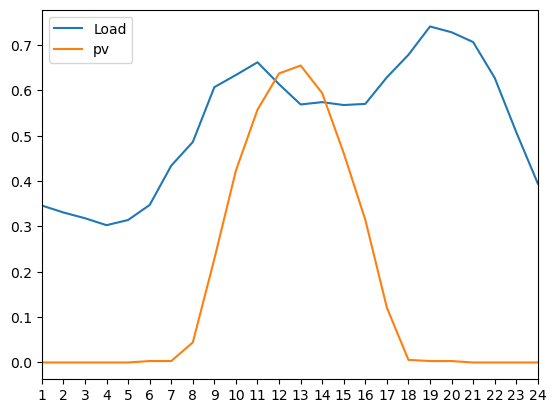

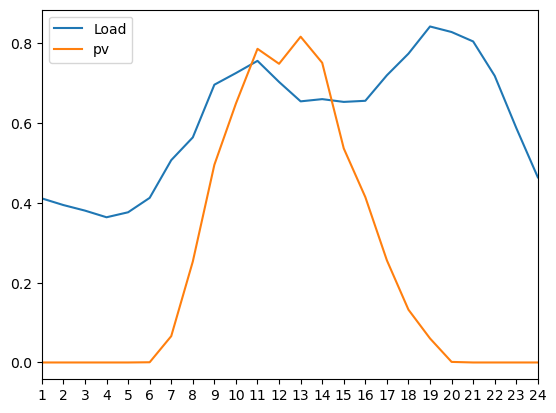

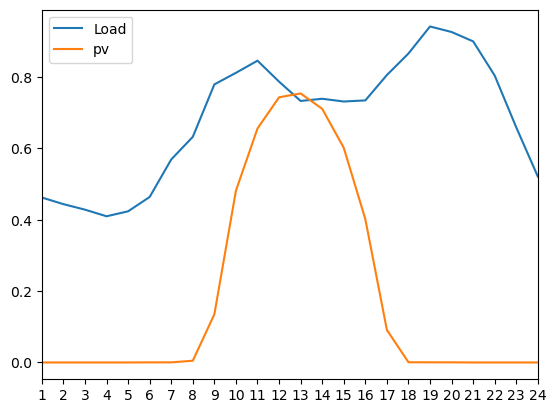

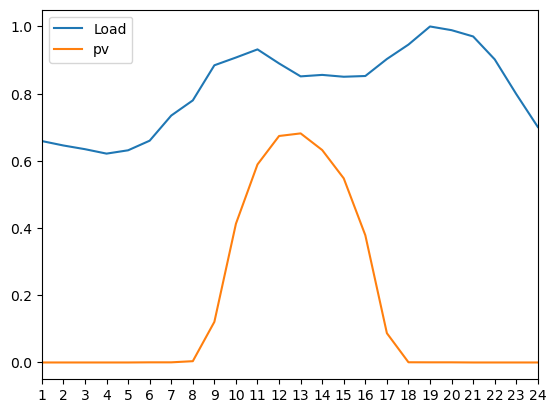

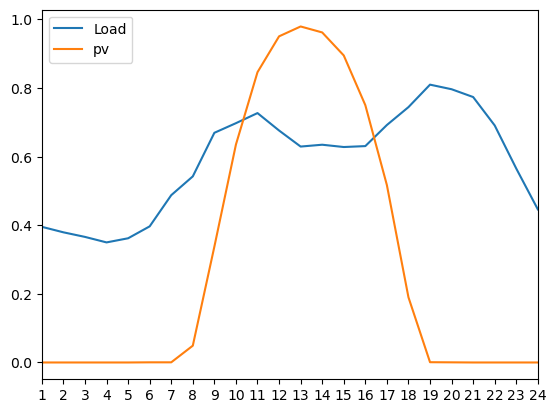

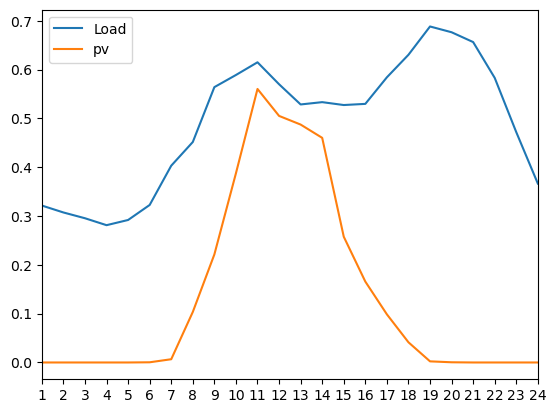

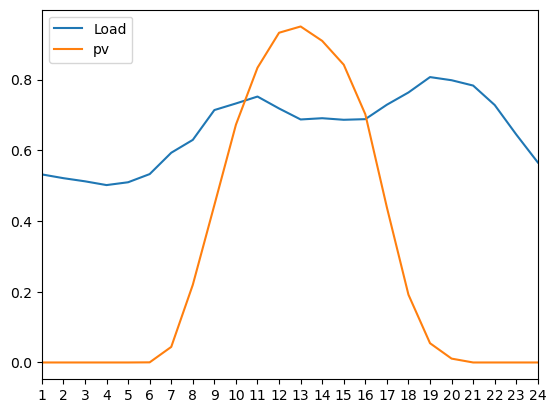

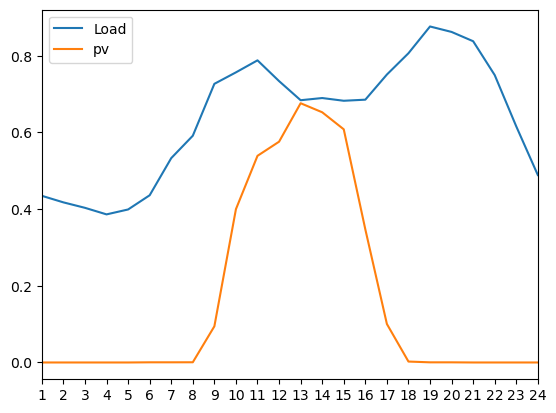

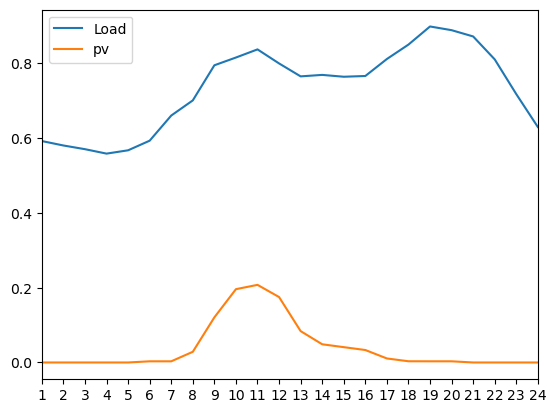

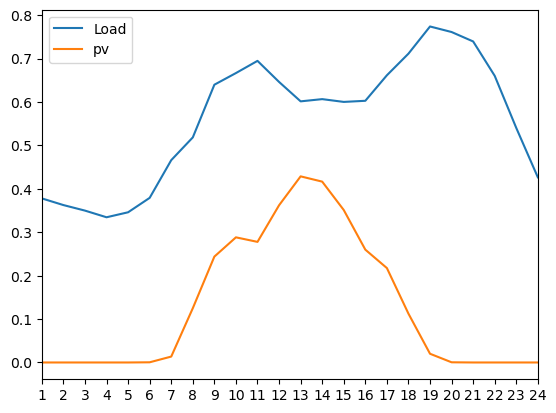

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
first_step: 9300491.242848245
first_step cap [5.5, array(7.42867539), array(3.), array(2.8794063), array(872.32973146)]
first_step cost [6600000.0, 1078266.518636367, 0.0, 817154.2924722751, 0.0, 300000.0, 46138.810351829445, 458931.6213878996]
freq_nadir: {0: array([[-1.38423047, -1.35588043, -1.3321643 , -1.30229425, -1.32483456,
        -1.38655809, -1.53156939, -1.50861613, -1.35729518, -1.333371  ,
        -1.31068463, -1.35133046, -1.3963632 , -1.39071239, -1.39777837,
        -1.3949476 , -1.33775731, -1.2984778 , -1.25550462, -1.26580215,
        -1.27945369, -1.33885873, -1.47450771, -1.4683363 ],
       [-1.26495157, -1.27365214, -1.28113208, -1.29068669, -1.28347383,
        -1.26422546, -1.22169488, -1.1965041 , -1.18477471, -0.8584216 ,
        -0.85833377, -0.85848775, -0.85863935, -0.8586215 , -0.85864384,
        -0.85863488, -1.17556447, -0.85828345, -0.85810377, -0.85813922,
   

In [ ]:
start = time.time()
# df_load = pd.read_csv("data/day_load.csv", header=None)
# load = df_load.values
# cluster_load = cluster_net_load(10*load)
# cluster_load.get_cluster()
# print('cluster finished')
# 直接读取负荷聚类的结果进行测算
file_list = ["data/day_load.csv", "data/day_pv.csv",
             "data/cluster_day.csv", "data/period.csv"]
data = read_data(file_list)
day_load, day_pv, cluster_day_num, period = data.get_data()
# df_day_load = pd.read_csv("data/load_day_data_cluster4.csv", header=None)
# day_load = df_day_load.values
# df_day_pv = pd.read_csv("data/pv_day_data_cluster4.csv", header=None)
# day_pv = df_day_pv.values
# df_cluster_day_num = pd.read_csv("data/cluster_day.csv", header=None)
# cluster_day_num = df_cluster_day_num.values[1]
# df_period = pd.read_csv("data/period.csv", header=None)
# period = df_period.values
day_num = day_load.shape[0]
# show cluster
for day_index in range(day_num):
        load_hour = day_load[day_index]
        pv_hour = day_pv[day_index]
        fig, axe = plt.subplots()
        x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
        labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
        axe.plot(x, load_hour, label="Load")
        axe.plot(x, pv_hour, label="pv")
        plt.xlim((1, 24))
        axe.set_xticks(x)
        axe.set_xticklabels(labels)
        axe.legend(loc='upper left')
        plt.show()
# first step
first_step = first_step_planning(day_load, day_pv, cluster_day_num, period)
(cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand,
cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, 
BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save,
freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, 
PV_inertia_response, BESS_inertia_response, SMR_damping_response) = first_step.get_initial_result()
print('first_step:', cost)
print('first_step cap', cap_com)
print('first_step cost', cost_com)
print('freq_nadir:', freq_nadir)
freq_iteration_process = freq_iteration(day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response)
(cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, 
SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, 
BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response) = freq_iteration_process.get_freq_ite_result()
PV_plan = {}
PV_plan[0] = cap_com[1]
print('overall cost:', cost)
print('cap_com:', cap_com)
print('cost_com:', cost_com)
cap_com_save_out = {}
SMR_output_save_out = {}
PV_output_save_out = {}
PV_output_cut_save_out = {}
BESS_charge_power_save_out = {}
BESS_discharge_power_save_out = {}
SESS_charge_power_save_out = {}
SESS_discharge_power_save_out = {}
cost_save_out = {}
cost_com_save_out = {}
freq_nadir_out = {}
SMR_droop_response_out = {}
PV_droop_response_out = {}
BESS_droop_response_out = {}
SMR_inertia_response_out = {}
PV_inertia_response_out = {}
BESS_inertia_response_out = {}
SMR_damping_response_out = {}
# save out0 variable
cap_com_save_out[0] = cap_com_save
SMR_output_save_out[0] = SMR_output_save
PV_output_save_out[0] = PV_output_save
PV_output_cut_save_out[0] = PV_output_cut_save
BESS_charge_power_save_out[0] = BESS_charge_power_save
BESS_discharge_power_save_out[0] = BESS_discharge_power_save
SESS_charge_power_save_out[0] = SESS_charge_power_save
SESS_discharge_power_save_out[0] = SESS_discharge_power_save
cost_save_out[0] = cost_save
cost_com_save_out[0] = cost_com_save
freq_nadir_out[0] = freq_nadir
SMR_droop_response_out[0] = SMR_droop_response
PV_droop_response_out[0] = PV_droop_response
BESS_droop_response_out[0] = BESS_droop_response
SMR_inertia_response_out[0] = SMR_inertia_response
PV_inertia_response_out[0] = PV_inertia_response
BESS_inertia_response_out[0] = BESS_inertia_response
SMR_damping_response_out[0] = SMR_damping_response
end = time.time()
print('Time used: ', end-start)

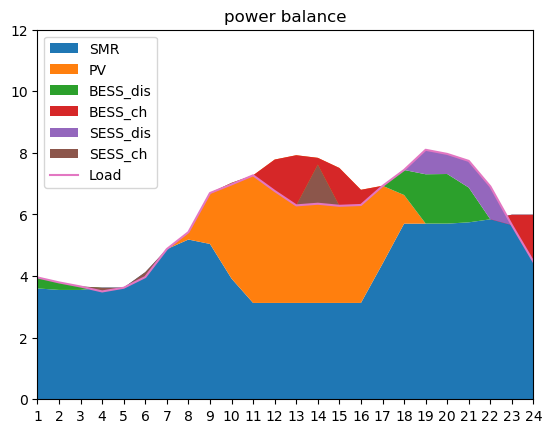

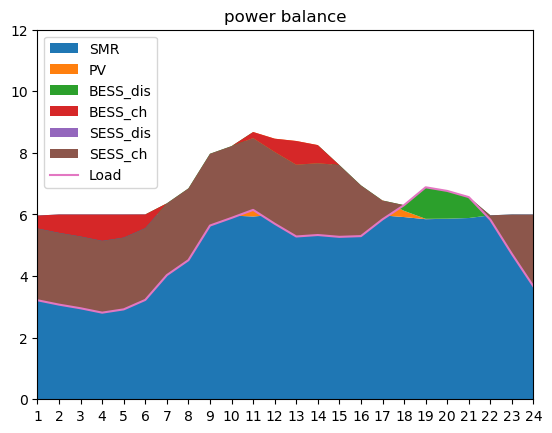

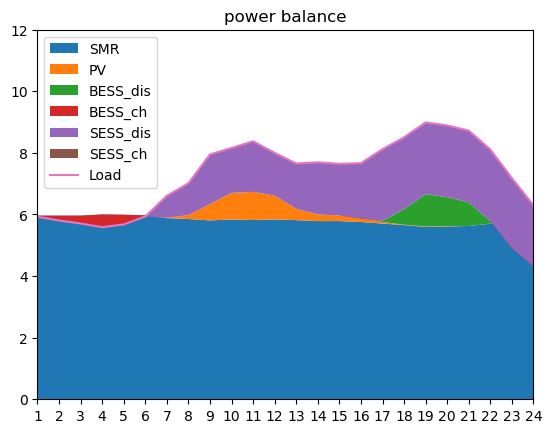

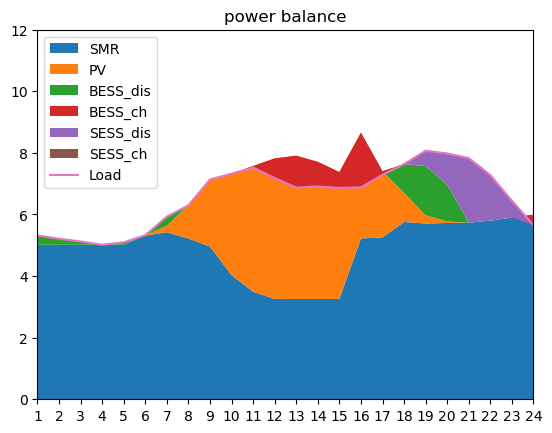

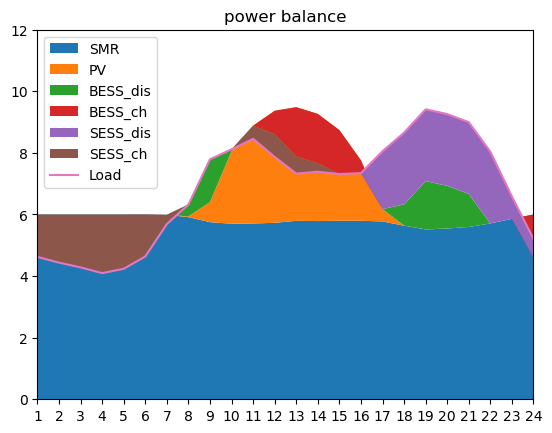

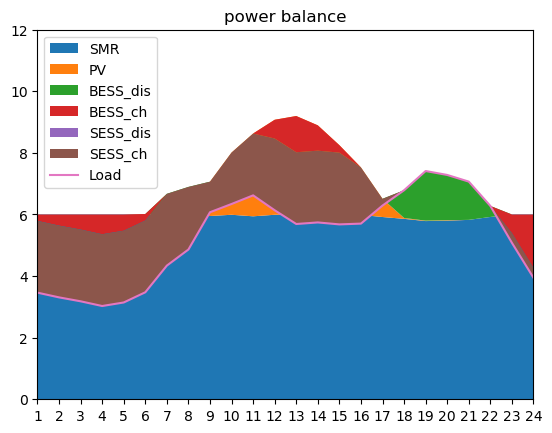

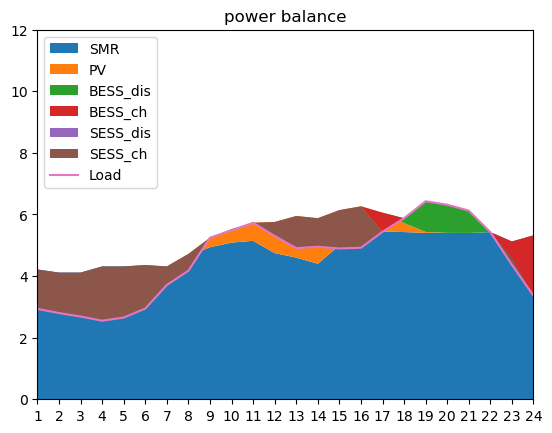

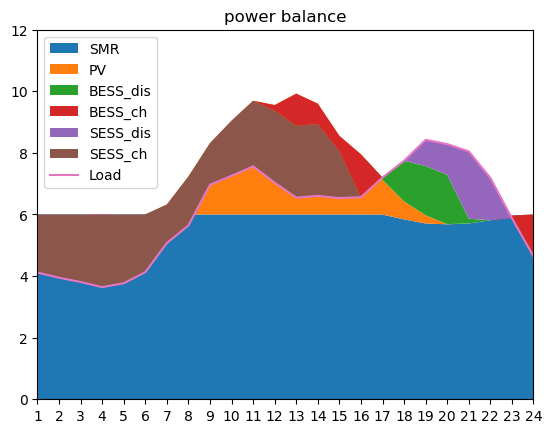

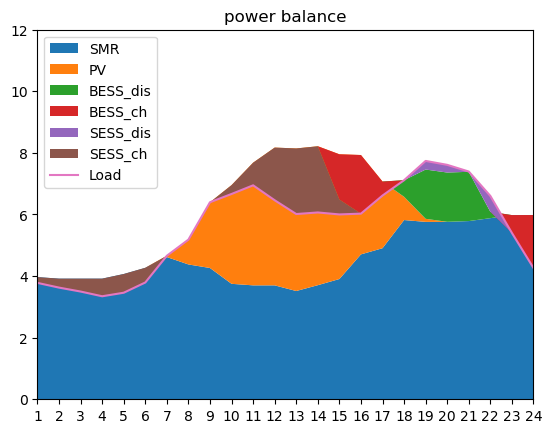

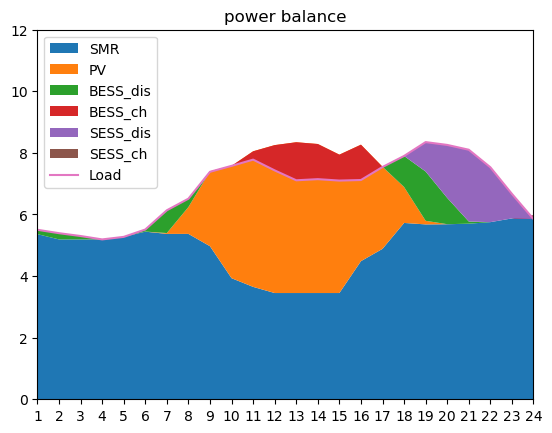

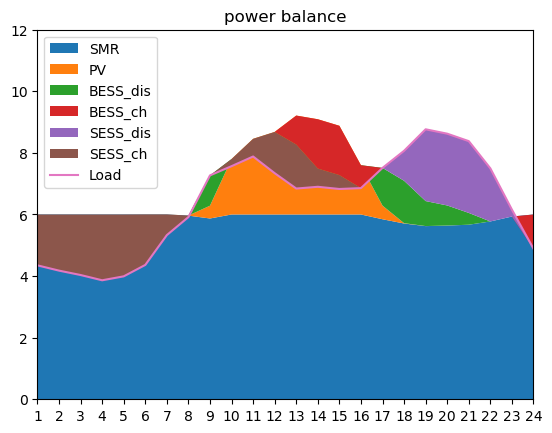

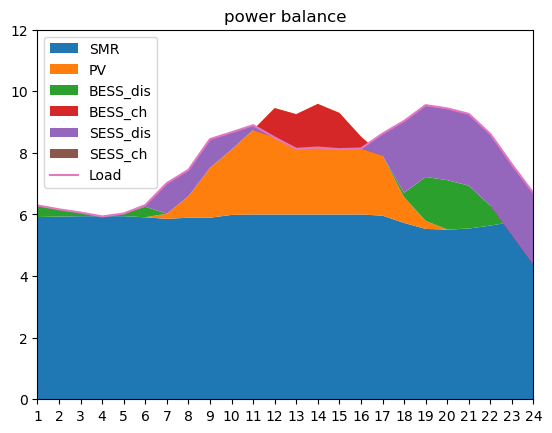

In [45]:
# show power balance result for each representative day
for day_index in range(day_num):
    SMR_p = SMR_output_save_out[0][0][day_index]
    PV_p = PV_output_save_out[0][0][day_index]
    BESS_pc = BESS_charge_power_save_out[0][0][day_index]
    BESS_pd = BESS_discharge_power_save_out[0][0][day_index]
    SESS_pc = SESS_charge_power_save_out[0][0][day_index]
    SESS_pd = SESS_discharge_power_save_out[0][0][day_index]
    load_hour = 10*day_load[day_index]
    y_SMR = SMR_p
    y_PV = PV_p
    y_BESS_pc = BESS_pc
    y_BESS_pd = BESS_pd
    y_SESS_pc = SESS_pc
    y_SESS_pd = SESS_pd
    fig, axe = plt.subplots()
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
    axe.stackplot(x, y_SMR, y_PV, y_BESS_pd, -y_BESS_pc, y_SESS_pd, -y_SESS_pc,
                  labels=["SMR", "PV", "BESS_dis", "BESS_ch", "SESS_dis", "SESS_ch"])
    axe.plot(x, load_hour, label="Load")
    plt.xlim((1, 24))
    plt.ylim((0, 12))
    axe.set_xticks(x)
    axe.set_xticklabels(labels)
    axe.set_title("power balance")
    axe.legend(loc='upper left')
    plt.show()

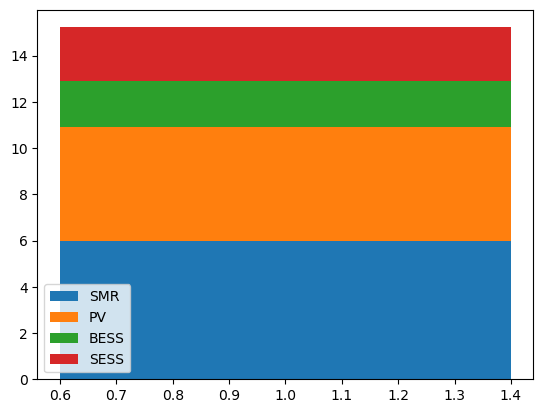

In [46]:
# capacity combination
SMR_capacity = cap_com_save_out[0][0][0]
PV_capacity = cap_com_save_out[0][0][1]
BESS_capacity = cap_com_save_out[0][0][2]
SESS_capcity = cap_com_save_out[0][0][3]
plt.bar(1, SMR_capacity, label='SMR')
plt.bar(1, PV_capacity, bottom=SMR_capacity, label='PV')
plt.bar(1, BESS_capacity, bottom=SMR_capacity+PV_capacity, label='BESS')
plt.bar(1, SESS_capcity, bottom=SMR_capacity+PV_capacity+BESS_capacity, label='SESS')
plt.legend()
plt.show()

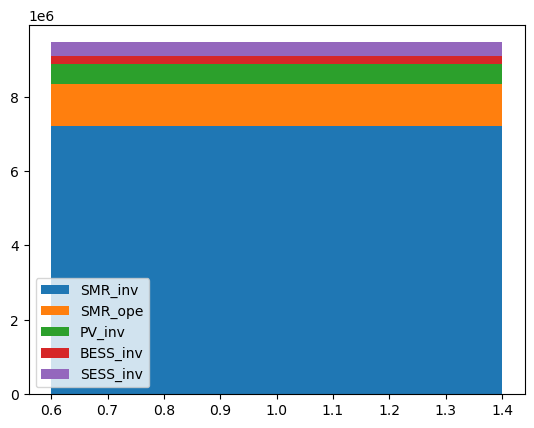

In [47]:
cost_com_save_out
# cost combination
SMR_inv_cost = cost_com_save_out[0][0][0]
SMR_ope_cost = cost_com_save_out[0][0][1]
PV_inv_cost = cost_com_save_out[0][0][3]
BESS_inv_cost = cost_com_save_out[0][0][5]
SESS_inv_cost = cost_com_save_out[0][0][7]
plt.bar(1, SMR_inv_cost, label='SMR_inv')
plt.bar(1, SMR_ope_cost, bottom=SMR_inv_cost, label='SMR_ope')
plt.bar(1, PV_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost, label='PV_inv')
plt.bar(1, BESS_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost+PV_inv_cost, label='BESS_inv')
plt.bar(1, SESS_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost+PV_inv_cost+BESS_inv_cost, label='SESS_inv')
plt.legend()
plt.show()

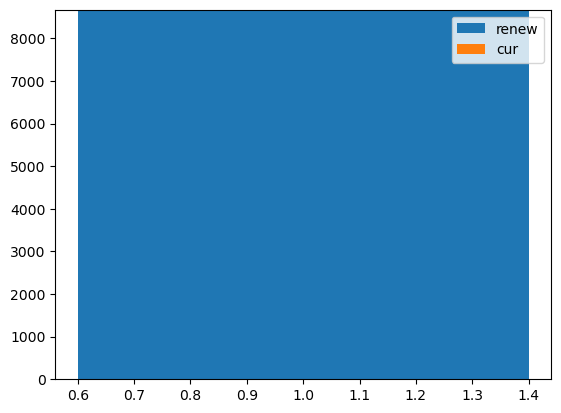

PV curtailment: 2.5978694881033132e-18


In [48]:
PV_output_save_out[0] = PV_output_save
PV_output_cut_save_out[0] = PV_output_cut_save
#  PV, wind curtailment
PV_power = 0
PV_cur = 0
PV_cur_vector = []
for day_index in range(day_num):
    day_index_num = cluster_day_num[day_index]
    P_PV = PV_output_save_out[0][0][day_index]*day_index_num
    P_PV_cur = PV_output_cut_save_out[0][0][day_index]*day_index_num
    PV_cur_vector.append(P_PV_cur)
    PV_power = PV_power + sum(P_PV)
    PV_cur = PV_cur + sum(P_PV_cur)
out = [PV_power]
cur = [PV_cur]
plt.bar(1, out, label='renew')
plt.bar(1, cur, bottom=out, label='cur')
# plt.xticks('PV')
plt.legend()
plt.show()
print('PV curtailment:', PV_cur/(PV_power+PV_cur))

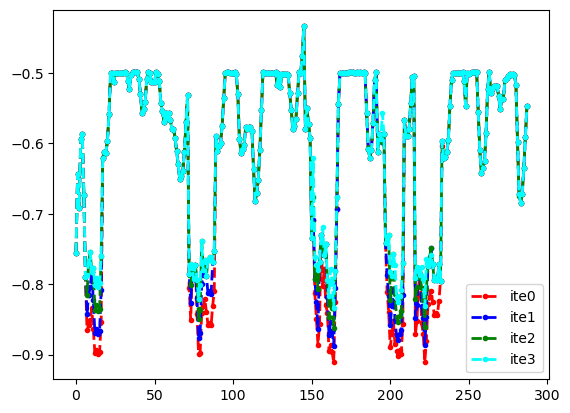

In [49]:
color_temp = ['red', 'blue', 'green', 'cyan', 'brown', 'magenta', 'yellow', 'gray', 'brown'] 
label_temp = ['ite0', 'ite1', 'ite2', 'ite3', 'ite4', 'ite5', 'ite6', 'ite7', 'ite8'] 
fig, ax = plt.subplots()
for temp in range(4):
    freq_value = freq_nadir_out[0][temp].flatten()
    ax.plot(freq_value, color=color_temp[temp], linestyle="dashed", linewidth=2, marker="o", markersize=3, label=label_temp[temp])
    ax.legend()
plt.show()

In [50]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [51]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [52]:
power_balance = {}
power_balance[0] = SMR_output_save[0]
power_balance[1] = PV_output_save[0]
power_balance[2] = BESS_charge_power_save[0]
power_balance[3] = BESS_discharge_power_save[0]
power_balance[4] = SESS_charge_power_save[0]
power_balance[5] = SESS_discharge_power_save[0]
power_balance[6] = 10*day_load
import pickle
# open a file to save the dictionary
with open('result/power_balance_cluster8.pickle', 'wb') as handle:
    pickle.dump(power_balance, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/power_balance_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [53]:
# show power balance result for each representative day
for day_index in range(day_num):
    SMR_p = SMR_output_save_out[16][3][day_index]
    PV_p = PV_output_save_out[16][3][day_index]
    BESS_pc = BESS_charge_power_save_out[16][3][day_index]
    BESS_pd = BESS_discharge_power_save_out[16][3][day_index]
    SESS_pc = SESS_charge_power_save_out[16][3][day_index]
    SESS_pd = SESS_discharge_power_save_out[16][3][day_index]
    # print('power:',SMR_p+PV_p+BESS_pd+SESS_pd)
    load_hour = SMR_p + PV_p + BESS_pd - BESS_pc + SESS_pd - SESS_pc;
    # print('out:',BESS_pc+SESS_pc+load_hour)
    y_SMR = SMR_p
    y_PV = PV_p
    y_BESS_pc = BESS_pc
    y_BESS_pd = BESS_pd
    y_SESS_pc = SESS_pc
    y_SESS_pd = SESS_pd
    fig, axe = plt.subplots()
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
    axe.stackplot(x, y_SMR, y_PV, y_BESS_pd, -y_BESS_pc, y_SESS_pd, -y_SESS_pc,
                  labels=["SMR", "PV", "BESS_dis", "BESS_ch", "SESS_dis", "SESS_ch"])
    axe.plot(x, load_hour, label="Load")
    plt.xlim((1, 24))
    plt.ylim((0, 15))
    axe.set_xticks(x)
    axe.set_xticklabels(labels)
    axe.set_title("power balance")
    axe.legend(loc='upper left')
    plt.show()

KeyError: 16

In [49]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [50]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [51]:
import pickle
# open a file to save the dictionary
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_nadir, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [52]:
freq_response = {}
freq_response[0] = 2*4.5*55/50
freq_response[1] = 0.6*55/50
freq_response[2] = SMR_droop
freq_response[3] = PV_droop
freq_response[4] = BESS_droop
freq_response[5] = 0.05*10*day_load
import pickle
# open a file to save the dictionary
with open('result/freq_response_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_response, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_response_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [53]:
my_test

{0: 9.9,
 1: 0.66,
 2: array([[0.34446776, 0.3712283 , 0.3087283 , 0.3087283 , 0.3087283 ,
         0.3712283 , 0.46562687, 0.5587283 , 0.6837283 , 0.6837283 ,
         0.75      , 0.75      , 0.6875    , 0.625     , 0.5625    ,
         0.5625    , 0.09550122, 0.14891045, 0.23279455, 0.22050122,
         0.18958209, 0.07497015, 0.        , 0.        ],
        [0.10349254, 0.08468657, 0.069     , 0.05019403, 0.06429851,
         0.10507463, 0.15846379, 0.10507463, 0.10529818, 0.05978326,
         0.05978326, 0.05978326, 0.05978326, 0.05978326, 0.05978326,
         0.05978326, 0.10522002, 0.31293241, 0.57644138, 0.61378579,
         0.57207463, 0.45001493, 0.30262687, 0.16307463],
        [0.3088209 , 0.13591132, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00992537, 0.04810448,
         0.08810448, 0.01901493, 0.        , 0.        , 0.        ,
         0.        , 0.04083582, 0.11174627, 0.20083582, 0.18265672,
         0.15174627, 0.03901493, 0

In [54]:
load_day_data = pd.DataFrame(day_load)
load_day_data.to_csv('result/load_day_data_cluster4.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [55]:
pv_day_data = pd.DataFrame(day_pv)
pv_day_data.to_csv('result/pv_day_data_cluster4.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [57]:
cap_com_save_out

{0: {0: [6.0,
   array(4.63447439),
   array(2.),
   array(3.00893708),
   array(927.68859886)],
  1: [6.0,
   array(4.63942123),
   array(2.),
   array(3.00888136),
   array(923.49126544)],
  2: [6.0,
   array(4.64471722),
   array(2.),
   array(3.00882171),
   array(923.22819137)],
  3: [6.0,
   array(4.64042912),
   array(2.),
   array(3.00887001),
   array(922.63607915)],
  4: [6.0,
   array(4.63638089),
   array(2.),
   array(3.00891561),
   array(926.07095139)],
  5: [6.0,
   array(4.63967767),
   array(2.),
   array(3.00887847),
   array(923.27367777)]},
 1: {0: [6.0,
   array(6.39882593),
   array(2.),
   array(2.39009839),
   array(838.67666142)],
  1: [6.0,
   array(6.39882593),
   array(2.),
   array(2.39009839),
   array(841.11650424)],
  2: [6.0,
   array(6.39882593),
   array(2.),
   array(2.39009839),
   array(838.67679882)],
  3: [6.0,
   array(6.39882593),
   array(2.),
   array(2.39009839),
   array(840.0760381)],
  4: [6.0,
   array(6.39882593),
   array(2.),
   arra

In [58]:
cost_com_save_out

{0: {0: [7200000.0,
   1163413.4790281684,
   0.0,
   509792.18236530054,
   0.0,
   200000.0,
   21808.42814430726,
   481671.9674492461],
  1: [7200000.0,
   1163088.023764928,
   0.0,
   510336.33566524653,
   0.0,
   200000.0,
   22047.795561541807,
   481119.62757191446],
  2: [7200000.0,
   1163340.3934142708,
   0.0,
   510918.8938265099,
   0.0,
   200000.0,
   22153.124232295722,
   481078.26949117106],
  3: [7200000.0,
   1164082.917491591,
   0.0,
   510447.2036929557,
   0.0,
   200000.0,
   22105.630917225917,
   481007.09101225476],
  4: [7200000.0,
   1163535.9092150333,
   0.0,
   510001.8984211338,
   0.0,
   200000.0,
   22332.08270137376,
   481459.09629591],
  5: [7200000.0,
   1163856.225451014,
   0.0,
   510364.54373713455,
   0.0,
   200000.0,
   22177.767056115816,
   481090.9945553484]},
 1: {0: [7200000.0,
   1121644.1722655331,
   0.0,
   703870.8522583862,
   0.0,
   200000.0,
   21532.508041118457,
   395839.77326394984],
  1: [7200000.0,
   1121798.860039